In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from generate_prob_chart import generate_prob_chart

In [2]:
prob = generate_prob_chart(False, False, False) # s | r | f | d

Let $d_i$ be a probability to arrive at StarForce $i+1$ starting from $i$. Then,
\begin{align*}
    d_i &= p_{i, s} + p_{i, f}(p_{i-1, s}d_i + p_{i-1, f}d_{i-1}d_i + p_{i-1, r}d_{i-1}d_i) + p_{i, r}d_i \\
    &= p_{i, s} + p_{i, f}d_i(p_{i-1, s} + p_{i-1, f}d_{i-1} + p_{i-1, r}d_{i-1}) + p_{i, r}d_i \\
    &= \frac{p_{i, s}}{1-p_{i, r}-p_{i, f}(p_{i-1, s} + (p_{i-1, r} + p_{i-1, f})d_{i-1})}
\end{align*}

Let $d_{i, j}$ be a probability to arrive at StarForce $j$ starting from $i$. Then,
\begin{align*}
    d_{i, j} &= d_{i, i+1} \times d_{i+1, i+2} \times \cdots \times d_{j-1, j} \\
    &= \prod_{k=i}^{j-1} d_k
\end{align*}

In [3]:
def dest_prob_analysis(starcatch=True, event_15=False, dest_prevention=False, pretty=False):
    prob = generate_prob_chart(starcatch, event_15, dest_prevention)
    dest_chart = pd.DataFrame(
        np.zeros((10, 10)),
        columns=range(15, 25),
        index=range(16, 26)
    )  # 15->16 ~ 24->25
    dest_chart = np.zeros((10, 10))  # 15->16 ~ 24->25
    dest_chart[-1, -1] = 1

    for end in range(10):
        start = end+15
        dest_chart[end, end] = prob[start, 0] / (
            1 - prob[start, 1] - prob[start, 2] * (
                    prob[start-1, 0] + prob[start-1, 1:3].sum()*dest_chart[end-1, end-1]
                )
        )

        for start in range(end):
            dest_chart[end, start] = dest_chart.diagonal()[start:end+1].prod()

    dest_chart = pd.DataFrame(
        dest_chart,
        columns=range(15, 25),
        index=range(16, 26),
    )

    if pretty is True:
        dest_chart = dest_chart.applymap(lambda x: '' if x==0 else f'{x:6.2%}')

    return dest_chart

In [4]:
dest_chart = dest_prob_analysis(False, False, False, round=4, pretty=True)
dest_chart

,15,16,17,18,19,20,21,22,23,24
16,93.46%,,,,,,,,,
17,76.73%,82.10%,,,,,,,,
18,55.09%,58.95%,71.80%,,,,,,,
19,35.11%,37.57%,45.76%,63.73%,,,,,,
20,20.63%,22.07%,26.88%,37.44%,58.75%,,,,,
21,16.72%,17.90%,21.80%,30.36%,47.64%,81.08%,,,,
22,10.26%,10.97%,13.37%,18.62%,29.21%,49.72%,61.33%,,,
23,0.66%,0.70%,0.86%,1.19%,1.88%,3.19%,3.94%,6.42%,,
24,0.01%,0.01%,0.02%,0.03%,0.04%,0.07%,0.08%,0.14%,2.12%,
25,,,,,,,,,0.02%,1.02%


+ Destruction count follows a geometric distribution. Let $a_n$ be the probability that $n$ times of destruction occurs.
\begin{align*}
    a_0 &= p \\
    a_n &= (1-S_{n-1})p \\
    S_n &= a_0 + \cdots + a_{n-1} + a_n \\
    &= a_0 + \cdots + a_{n-1} + -pS_{n-1} + p \\
    &= (1-p)S_{n-1} + p \\
    \Rightarrow S_n - 1 &= (1-p)(S_{n-1} - 1) \\
    S_0 - 1 &= -(1-p), \quad S_n - 1 = -(1-p) \cdot (1-p)^n = -(1-p)^{n+1} \\
    S_n &= 1 - (1-p)^{n+1} \underset{n\rightarrow\infty}{\rightarrow} 1 \\
    a_n &= S_n - S_{n-1} = (1-p)^n - (1-p)^{n+1} = (1-p)^n p
\end{align*}
+ Let $b_n$ be the probability that $n \geq 1$ pure items are required. Then, $b_n = (1-p)^{n-1}p$. Hence, destruction count or required amount of pure items follows geometric distribution.

In [5]:
def draw_dest_prop(start, end, starcatch=False, event_15=False, dest_prevention=False, max_dest=10):
    dest_chart = dest_prob_analysis(starcatch, event_15, dest_prevention, round=False)
    dest_prop = []
    dest_prop.append(dest_chart.loc[end, start])
    for _ in range(max_dest):
        dest_prop.append((1-sum(dest_prop)) * dest_chart.loc[end, 15])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(14, 4))
    bool_to_text = lambda x: "O" if x is True else "X"
    fig.suptitle(f'StarForce {start:2d} -> {end:2d}\nStarcatch: {bool_to_text(starcatch):>14s}\n15+1: \
                 {bool_to_text(event_15):>19s}\nDestruction Prevention: {bool_to_text(dest_prevention):1s}')
    fig.subplots_adjust(bottom=0, top=0.775)

    ax1.bar(range(max_dest+1), dest_prop)
    ax1.set_xlabel('Destruction Count')
    ax1.set_ylabel('Proportion')
    ax1.set_ylim((0, np.ceil(dest_prop[0]*10)/10))
    ax1.set_xticks(range(max_dest+1), range(max_dest+1))
    ax1.set_yticklabels([f'{prop:5.1%}' for prop in ax1.get_yticks()])
    ax1.set_title('individual')

    ax2.bar(range(max_dest+1), [sum(dest_prop[:i+1]) for i in range(max_dest+1)])
    ax2.set_xlabel('Cumulative Destruction Count')
    ax2.set_ylabel('Proportion')
    ax2.set_ylim((0, 1))
    ax2.set_xticks(range(max_dest+1), range(max_dest+1))
    ax2.set_yticks([0.1*i for i in range(max_dest+1)], [f'{0.1*i:4.0%}' for i in range(max_dest+1)])
    ax2.set_title(f'cumulative')

    return dest_prop

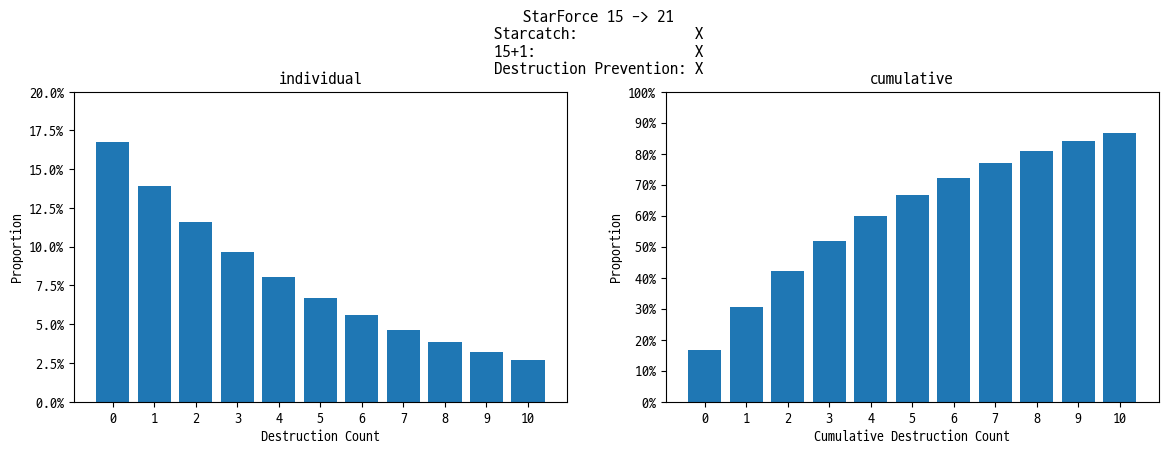

In [6]:
dest_prop = draw_dest_prop(15, 21)

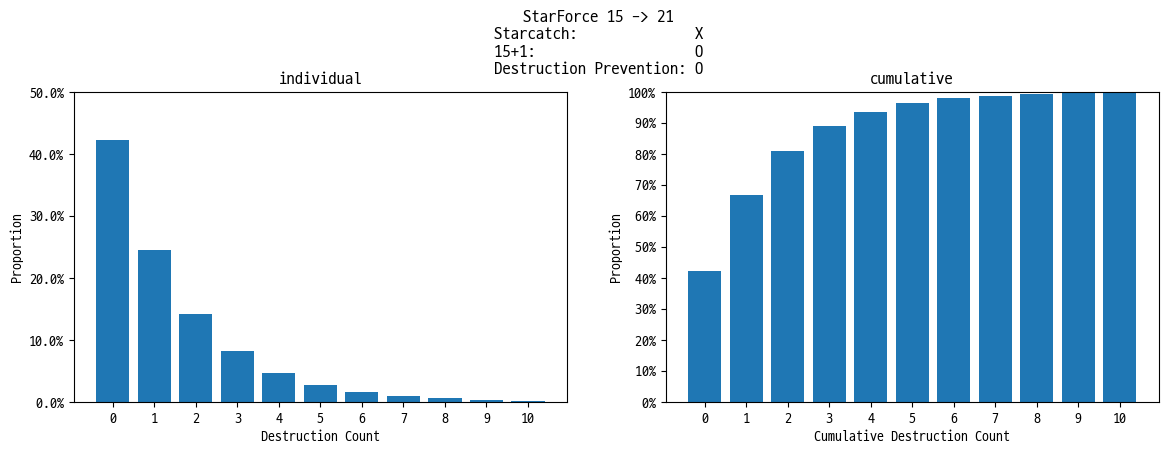

In [7]:
dest_prop = draw_dest_prop(15, 21, False, True, True)